In [1]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from itertools import cycle
import einops
from tqdm.auto import tqdm
import random
from torch.distributions import Categorical
import torch

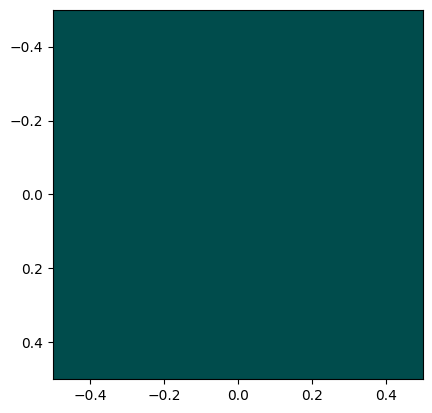

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random pixel values for the image
image_data = np.random.rand(1, 1, 3)  # 100x100 image with 3 color channels (RGB)
image_data[0,0,:] = 0.3
image_data[0,0,0] = 0
# Display the image
plt.imshow(image_data)
plt.show()

In [38]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

class CustomMNISTDataset(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, background_color=(0, 0, 0)):
        self.original_mnist = datasets.MNIST(
            root=root,
            train=train,
            transform=transform,
            download=download
        )
        self.background_color = background_color
        self.mean = torch.mean(self.original_mnist.data.float()) / 255
        self.stddev = torch.std(self.original_mnist.data.float()) / 255

    def __len__(self):
        return len(self.original_mnist)

    def __getitem__(self, idx):
        image, target = self.original_mnist[idx]
        image = torch.Tensor(np.array(image))
        image = (image.float() / 255 - self.mean) / self.stddev
        a = einops.repeat(image.squeeze(0), 'h w -> c h w', c=3)
        # rr,rg,rb = random.random(), random.random(), random.random()
        # b = torch.zeros_like(a)
        # b[0] = torch.where(a[0] < 0.1 , rr, a[0])
        # b[1] = torch.where(a[1] < 0.1 , rg, a[0])
        # b[2] = torch.where(a[2] < 0.1 , rb, a[0])

        return a, target

transform = transforms.Compose([
    transforms.Resize((28, 28)),   # Resize to MNIST image size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Create the custom dataset
custom_mnist = CustomMNISTDataset(
    root="./data",
    train=True,
    transform=None,
    download=True,
    background_color=(0, 0, 250)  # Blue background (change as desired)
)

In [39]:
training_dataset = CustomMNISTDataset('./data')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


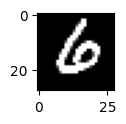

In [43]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(1, 1))
plt.imshow(training_dataset[83][0].numpy().transpose(1,2,0))
plt.show()


In [54]:
from torch.utils.data import DataLoader
import torch.nn as nn

train_dataloader = DataLoader(training_dataset, batch_size=16, shuffle=True, drop_last=True)

In [55]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=512):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Add a batch dimension

    def forward(self, x):
        # Add the positional encodings to the input embeddings
        return x + self.encoding[:, :x.size(1)].detach()

In [56]:
import torch
import torch.nn as nn

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(LearnablePositionalEncoding, self).__init__()
        self.positional_encoding = nn.Parameter(torch.randn(max_len, d_model))

    def forward(self, x):
        # Assuming x has shape [batch, len, dim]
        batch_size, seq_len, _ = x.size()

        # Broadcast positional encoding to match the shape of x
        positional_encoding = self.positional_encoding[:seq_len].unsqueeze(0).expand(batch_size, -1, -1)
        
        # Mahdi Code
        #norms = torch.norm(positional_encoding, p=2, dim=2, keepdim=True)
        #positional_encoding = positional_encoding / norms


        # Add positional encoding to the input tensor
        output = x + positional_encoding

        return output

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops

class SimpleSender(nn.Module):
    def __init__(self, alph_size=10):
        super(SimpleSender, self).__init__()
        self.alph_size = alph_size
        # Define your layers or modules here
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=576, out_features=64)
        self.positional_encoding = LearnablePositionalEncoding(64)
        self.rnn = nn.LSTM(64, 64, 1, batch_first=True)
        self.fc3 = nn.Linear(in_features=64, out_features=self.alph_size)


    def forward(self, x, len_message=3):
        # x = [b, 1, 1, 3] -> [b, l, d]
        x = F.leaky_relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.flatten(start_dim=1)
        x = F.leaky_relu(self.fc1(x))
        x = einops.repeat(x, 'b d -> b l d', l = len_message)
        x = self.positional_encoding(x)
        x, _ = self.rnn(x)
        x = self.fc3(x)
        return x

    def forward_continuous(self, x, len_message=3):
        # x = [b, 1, 1, 3] -> [b, d]
        x = F.leaky_relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.flatten(start_dim=1)
        x = F.leaky_relu(self.fc1(x))
        x = einops.repeat(x, 'b d -> b l d', l = len_message)
        x = self.positional_encoding(x)
        x, _ = self.rnn(x)
        x = self.fc3(x)
        x = x.mean(dim=1)
        return x

m1 = SimpleSender()
x = torch.randn((20, 3, 28, 28))
m1(x).shape

torch.Size([20, 3, 10])

In [58]:
class SimpleReceiver(nn.Module):
    def __init__(self, alph_size=10):
        super(SimpleReceiver, self).__init__()
        self.alph_size = alph_size
        ### Image Side
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=576, out_features=16)
        ### Text Side
        self.emb = nn.Embedding(self.alph_size, 16)
        self.fc3 = nn.Linear(in_features=16, out_features=16)
        self.positional_encoding = LearnablePositionalEncoding(16)
        self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=16, nhead=1, batch_first=True, dim_feedforward=16, activation=F.leaky_relu), num_layers=2)



    def forward_image(self, x):
        # x = [b, 3, 28, 28] -> [b, d]
        x = F.leaky_relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.flatten(start_dim=1)
        x = F.leaky_relu(self.fc1(x))
        return x

    def forward_text(self, x, src_key_padding_mask=None):
        # x = [b, l] long Tensor -> [b, d]
        x = F.leaky_relu(self.emb(x))
        x = self.fc3(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        # x = x.mean(dim=1)
        x = x[:,0,:]
        return x

In [59]:
def create_mask_after_end_token(input_tensor, end_token_id):
    ### [b, l] -> [b, l]
    # Find the index of the [END] token in each row
    end_token_indices = torch.nonzero(input_tensor == end_token_id)

    # Create a mask tensor of the same shape as the input tensor
    mask_tensor = torch.zeros_like(input_tensor)

    # Set elements after the [END] token index in each row to 1
    for batch_idx, end_idx in end_token_indices:
        mask_tensor[batch_idx, end_idx + 1:] = 1

    return mask_tensor
     

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [91]:
x = torch.randn((20, 3, 28, 28)).to(device)
m1 = m1.to(device)
words = m1(x).argmax(axis=2)
words_mask = create_mask_after_end_token(words, 0).bool().to(device)
m2 = SimpleReceiver().to(device)
m2.forward_text(words, words_mask).shape

torch.Size([20, 16])

In [116]:
m1 = SimpleSender(10).to(device)
m2 = SimpleReceiver(10).to(device)
m2_optimizer = torch.optim.Adam(m2.parameters(), lr=1e-3, weight_decay=0e-6)
m1_optimizer = torch.optim.Adam(m1.parameters(), lr=1e-3, weight_decay=0e-6)

In [117]:
import time
from torch.distributions import Categorical
import copy

len_message = 1
eaaly_stop_acc = 0.99
max_steps = 2000
log_period_steps = 200
entropy_loss_lambda = 10e-1

data_iterator = iter(train_dataloader)
acc_list = []
loss_list = []
last_acc, best_acc = 0, 0
best_model_state = None, None
for iter_num in tqdm(range(max_steps)):
  try:
    batch, _ = next(data_iterator)
  except StopIteration:
    data_iterator = iter(train_dataloader)
    batch, _ = next(data_iterator)
    a = batch
  batch = batch.to(device)
  m2_optimizer.zero_grad()
  m1_optimizer.zero_grad()
  ###
  message_logits = m1(batch.float(), len_message)
  message = message_logits.argmax(2) ### [batch, len, alph_size]
  message_mask = create_mask_after_end_token(message, 0).float()
  m2_img_rprs = m2.forward_image(batch.float())
  m2_mess_rprs = m2.forward_text(message, message_mask)
  rolled_m2_img_rprs = torch.roll(m2_img_rprs, shifts=1, dims=0)
  pos_similarity = F.cosine_similarity(m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  neg_similarity = F.cosine_similarity(rolled_m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  similarity_scores = torch.cat([pos_similarity, neg_similarity], axis=1)
  m2_loss = F.cross_entropy(similarity_scores, torch.LongTensor([0]*similarity_scores.shape[0]).to(device))
  m2_loss.backward()
  m2_optimizer.step()
  ###
  log_probs = torch.log(torch.gather(F.softmax(message_logits, dim=2), 2, message.unsqueeze(2)))
  rewards = -1*F.cross_entropy(similarity_scores, torch.LongTensor([0]*similarity_scores.shape[0]).to(device), reduction='none').detach()
  returns = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
  #####
  temp = (1-message_mask.unsqueeze(2)*log_probs)
  temp2 = (returns.unsqueeze(1) * temp.squeeze(2))
  m1_loss = temp2.sum() / ((1-message_mask).sum())
  m1_loss = -torch.mean(returns * log_probs)
  ####
  m1_internal_repr = m1.forward_continuous(batch.float())
  m1_internal_repr_aug = m1.forward_continuous(batch.float() + 1 * torch.randn_like(batch, device=device))
  cosine_sim = F.cosine_similarity(m1_internal_repr.unsqueeze(1), m1_internal_repr_aug.unsqueeze(0), dim=2)
  m1_internal_loss = F.cross_entropy(cosine_sim, torch.arange(batch.shape[0]).to(device))
  m1_loss = 1*m1_loss + 0.5 * m1_internal_loss
  ###
  entropy_loss = -Categorical(F.softmax(message_logits, dim=2)).entropy()
  entropy_loss_masked = (((1-message_mask)*entropy_loss)/((1-message_mask).sum())).sum()
  (m1_loss + entropy_loss_lambda*entropy_loss_masked).backward()
  m1_optimizer.step()
  acc = (1 - similarity_scores.argmax(1)).float().mean()
  acc = (last_acc + acc)/2
  acc_list.append(acc.item())
  last_acc = acc
  loss_list.append(m2_loss.item())
  if acc > best_acc:
    print(f"step {iter_num} :", acc.item())
    best_acc = acc
    best_model_state = copy.deepcopy(m1.state_dict()), copy.deepcopy(m2.state_dict())
  if acc.item() > eaaly_stop_acc:
    print(f"step {iter_num} :", acc.item())
    break
  if iter_num % log_period_steps == 0:
    print(f"step {iter_num} :",rewards.mean().item(), m1_loss.item(), entropy_loss_masked.item())

m1.load_state_dict(best_model_state[0])
m2.load_state_dict(best_model_state[1])

  0%|          | 0/2000 [00:00<?, ?it/s]

step 0 : 0.25
step 0 : -0.6924221515655518 1.3860886096954346 -2.297379493713379
step 1 : 0.3125
step 2 : 0.4375
step 5 : 0.46875
step 7 : 0.5390625
step 8 : 0.61328125
step 9 : 0.619140625
step 10 : 0.6220703125
step 13 : 0.6480712890625
step 16 : 0.6591339111328125
step 17 : 0.6733169555664062
step 21 : 0.6905198097229004
step 34 : 0.7471851110458374
step 37 : 0.7730856537818909
step 41 : 0.7905053496360779
step 45 : 0.7915940880775452
step 46 : 0.8020470142364502
step 50 : 0.8196591734886169
step 64 : 0.8216137290000916
step 73 : 0.8263117074966431
step 91 : 0.8460653424263
step 98 : 0.8669614791870117
step 104 : 0.8836634755134583
step 108 : 0.9028851985931396
step 119 : 0.9358656406402588
step 200 : -0.6762487888336182 1.0264039039611816 -2.299975872039795
step 400 : -0.5045798420906067 0.9792238473892212 -2.3001291751861572
step 600 : -0.5443973541259766 0.9890953302383423 -2.300481081008911
step 800 : -0.5988147854804993 0.9510836601257324 -2.3014883995056152
step 971 : 0.945091

<All keys matched successfully>

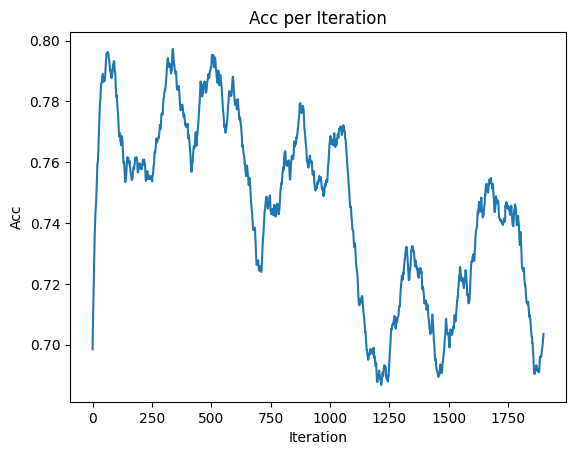

In [118]:
import numpy as np
import matplotlib.pyplot as plt
win_size = 100
smoothed_accuracy = np.convolve(acc_list, np.ones(win_size) / win_size, mode='valid')
plt.plot(smoothed_accuracy)
plt.xlabel('Iteration')
plt.ylabel('Acc')
plt.title('Acc per Iteration')
plt.show()


In [119]:
from collections import defaultdict

messages = list()
image_dictionary = defaultdict(list)

for batch, _ in tqdm(train_dataloader):
  batch = batch.to(device)
  message_logits = m1(batch.float(), len_message)
  message = message_logits.argmax(2) ### [batch, len, alph_size]
  message_mask = create_mask_after_end_token(message, 0).float()
  m2_img_rprs = m2.forward_image(batch.float())
  m2_mess_rprs = m2.forward_text(message, message_mask)
  rolled_m2_img_rprs = torch.roll(m2_img_rprs, shifts=1, dims=0)
  pos_similarity = F.cosine_similarity(m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  neg_similarity = F.cosine_similarity(rolled_m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  similarity_scores = torch.cat([pos_similarity, neg_similarity], axis=1)
  m2_loss = F.cross_entropy(similarity_scores, torch.LongTensor([0]*similarity_scores.shape[0]).to(device))
  rewards = 1 - similarity_scores.argmax(1).float()
  messages.append(message)
  if len(messages) > 40:
    break
  print(rewards.mean())

  for i, m in enumerate(message):
    sentence = ""
    for token in m:
      sentence = sentence + str(token.item())
      if sentence[-1] == '0':
        break
    image_dictionary[sentence].append(batch[i])


  0%|          | 0/3750 [00:00<?, ?it/s]

tensor(0.6250, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor(0.5625, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(1

In [120]:
image_dictionary = dict(sorted(image_dictionary.items(), key=lambda item: item[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

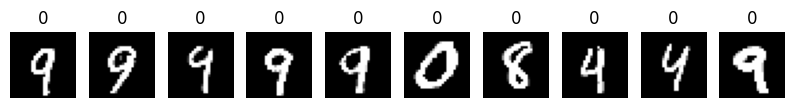

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

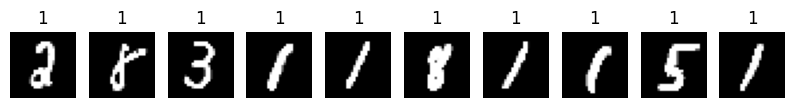

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

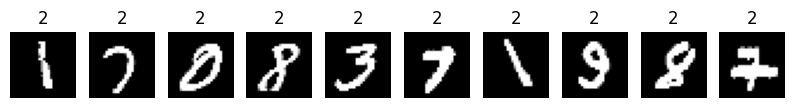

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

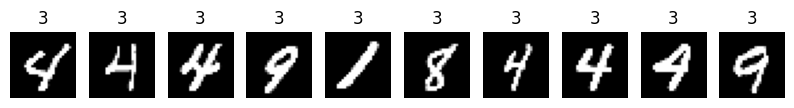

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

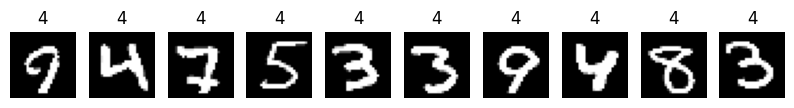

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

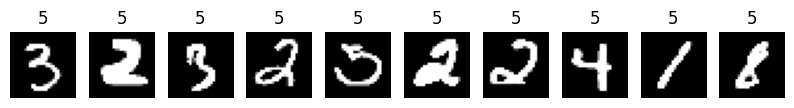

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

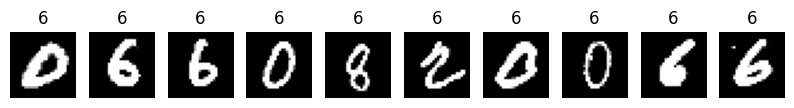

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

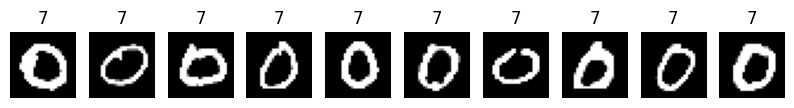

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

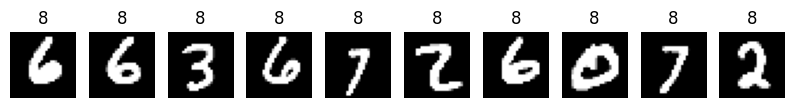

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

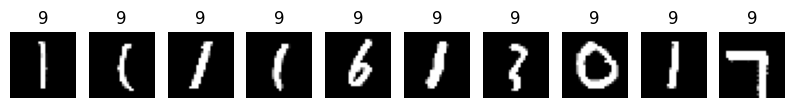

In [121]:
import matplotlib.pyplot as plt

max_image_per_token = 10
for sentence, image_indices in image_dictionary.items():
    image_indices = image_indices[:max_image_per_token]
    num_images = len(image_indices)

    if num_images == 1:
        fig = plt.figure(figsize=(1, 1))
        axs = [plt.subplot(1, 1, 1)]
    else:
        fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1))
    
    for i, image in enumerate(image_indices):
        axs[i].imshow(image.cpu().numpy().transpose(1,2,0))
        axs[i].set_title(f"{sentence}")
        axs[i].axis('off')

    plt.show()
